In [1]:
import numpy as np
import itertools
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
from scipy.stats import linregress

from armored.models import *
from armored.preprocessing import *

import time

np.random.seed(12345)

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


# Define variable names

In [2]:
# define system variables
species = ["s"+str(i+1) for i in range(5)]
ns = len(species)
controls = ["dt"]
metabolites = []
system_variables = np.concatenate((species, metabolites))
system_variables

array(['s1', 's2', 's3', 's4', 's5'], dtype='<U32')

## Import sum-of-OD data and community data

In [3]:
sum_data = pd.read_csv("gLV_data/Simulated_gLV_data_sum.csv").rename(columns={"Treatments":"Experiments"})
full_data = pd.read_csv("gLV_data/Simulated_gLV_data_full.csv").rename(columns={"Treatments":"Experiments"})

#sum_data = pd.read_csv("CR_data/CR_data_sum.csv")
#full_data = pd.read_csv("CR_data/CR_data_full.csv")

sum_data

,Experiments,Time,OD,s1,s2,s3,s4,s5
0,exp_1,0.000000,0.277501,0.099994,0.006488,0.012792,0.084853,0.073373
1,exp_1,1.066667,0.290812,0.103724,-0.003688,0.004913,0.102808,0.083056
2,exp_1,2.133333,0.348791,0.107753,0.016149,0.018098,0.123503,0.083288
3,exp_1,3.200000,0.372848,0.107044,0.016229,0.013457,0.150790,0.085329
4,exp_1,4.266667,0.445272,0.112630,0.049533,0.018063,0.170072,0.094973
...,...,...,...,...,...,...,...,...
1003,mono_exp_63,11.733333,0.142563,0.000000,0.000000,0.000000,0.000000,0.142563
1004,mono_exp_63,12.800000,0.137750,0.000000,0.000000,0.000000,0.000000,0.137750
1005,mono_exp_63,13.866667,0.133803,0.000000,0.000000,0.000000,0.000000,0.133803
1006,mono_exp_63,14.933333,0.136663,0.000000,0.000000,0.000000,0.000000,0.136663


In [4]:
full_data

,Experiments,Time,s1,s2,s3,s4,s5
0,exp_1,0.0,0.100000,0.100000,0.100000,0.100000,0.100000
1,exp_1,16.0,0.138713,0.300715,0.021561,0.228851,0.028723
2,exp_2,0.0,0.100000,0.100000,0.100000,0.100000,0.000000
3,exp_2,16.0,0.144219,0.303441,0.007713,0.236103,0.000000
4,exp_3,0.0,0.100000,0.100000,0.100000,0.000000,0.100000
...,...,...,...,...,...,...,...
57,exp_29,16.0,0.000000,0.000000,0.000000,0.185392,0.068325
58,mono_exp_30,0.0,0.000000,0.000000,0.000000,0.100000,0.000000
59,mono_exp_30,16.0,0.000000,0.000000,0.000000,0.182416,0.000000
60,mono_exp_31,0.0,0.000000,0.000000,0.000000,0.000000,0.100000


In [5]:
# add time step as control variable 
dt_max = np.max(np.diff(full_data.Time.values))
sum_data_dt = []
for name, df in sum_data.groupby("Experiments"):
    df_dt = df.copy()
    df_dt["dt"] = np.diff(df.Time.values, append=2*df.Time.values[-1]-df.Time.values[-2]) / dt_max
    sum_data_dt.append(df_dt)
sum_data_dt = pd.concat(sum_data_dt)

# add time step as control variable 
full_data_dt = []
for name, df in full_data.groupby("Experiments"):
    df_dt = df.copy()
    df_dt["dt"] = np.diff(df.Time.values, append=2*df.Time.values[-1]-df.Time.values[-2]) / dt_max
    full_data_dt.append(df_dt)
full_data_dt = pd.concat(full_data_dt)

# Define compression functions

In [6]:
# define compression functions 
C0 = np.atleast_2d(np.ones(ns))
C1 = np.eye(ns)
C = [C0, C1]

In [22]:
# format data frames
X, U, Y, _ = format_data(sum_data_dt, species, metabolites, controls, observed=species)
# Xf, Uf, Yf, _ = format_data(full_data_dt, species, metabolites, controls, observed=species)

In [8]:
# normalize data ?
# Y_max = np.max(Y, 0)
# Yf_max = np.max(Yf, 0)

In [23]:
data = [(X, U, Y)] #, (Xf, Uf, Yf)]

## Init MiRNN

In [26]:
# init model
brnn = miRNN(n_species=len(species), n_metabolites=len(metabolites), n_controls=len(controls),
             n_hidden=16, alpha_0=1., param_0=1.)

# fit model
brnn.fit(data, C=[C1], map_tol=.001, evd_tol=.001, lr=.01)

Epoch: 0, Loss: 1467.22284, Residuals: 0.07007, Convergence:   inf
Epoch: 1, Loss: 1439.39232, Residuals: 0.06937, Convergence: 0.019335
Epoch: 2, Loss: 1412.13343, Residuals: 0.06867, Convergence: 0.019303
Epoch: 3, Loss: 1385.41363, Residuals: 0.06799, Convergence: 0.019287
Epoch: 4, Loss: 1359.26604, Residuals: 0.06731, Convergence: 0.019237
Epoch: 5, Loss: 1333.70449, Residuals: 0.06663, Convergence: 0.019166
Epoch: 6, Loss: 1308.70374, Residuals: 0.06597, Convergence: 0.019103
Epoch: 7, Loss: 1284.22545, Residuals: 0.06531, Convergence: 0.019061
Epoch: 8, Loss: 1260.23533, Residuals: 0.06466, Convergence: 0.019036
Epoch: 9, Loss: 1236.70735, Residuals: 0.06401, Convergence: 0.019025
Epoch: 10, Loss: 1213.62012, Residuals: 0.06337, Convergence: 0.019023
Epoch: 11, Loss: 1190.96578, Residuals: 0.06274, Convergence: 0.019022
Epoch: 12, Loss: 1168.73217, Residuals: 0.06211, Convergence: 0.019024
Epoch: 13, Loss: 1146.91097, Residuals: 0.06149, Convergence: 0.019026
Epoch: 14, Loss: 11

Epoch: 118, Loss: 168.41955, Residuals: 0.02062, Convergence: 0.017667
Epoch: 119, Loss: 165.49562, Residuals: 0.02042, Convergence: 0.017668
Epoch: 120, Loss: 162.63845, Residuals: 0.02021, Convergence: 0.017568
Epoch: 121, Loss: 159.83043, Residuals: 0.02000, Convergence: 0.017569
Epoch: 122, Loss: 157.07030, Residuals: 0.01980, Convergence: 0.017573
Epoch: 123, Loss: 154.35877, Residuals: 0.01960, Convergence: 0.017566
Epoch: 124, Loss: 151.70831, Residuals: 0.01940, Convergence: 0.017471
Epoch: 125, Loss: 149.10519, Residuals: 0.01920, Convergence: 0.017458
Epoch: 126, Loss: 146.55505, Residuals: 0.01901, Convergence: 0.017401
Epoch: 127, Loss: 144.04627, Residuals: 0.01882, Convergence: 0.017417
Epoch: 128, Loss: 141.59775, Residuals: 0.01862, Convergence: 0.017292
Epoch: 129, Loss: 139.17982, Residuals: 0.01844, Convergence: 0.017373
Epoch: 130, Loss: 136.81441, Residuals: 0.01825, Convergence: 0.017289
Epoch: 131, Loss: 134.48983, Residuals: 0.01807, Convergence: 0.017284
Epoch:

Epoch: 236, Loss: 29.86524, Residuals: 0.00732, Convergence: 0.010536
Epoch: 237, Loss: 29.55942, Residuals: 0.00726, Convergence: 0.010346
Epoch: 238, Loss: 29.25770, Residuals: 0.00720, Convergence: 0.010312
Epoch: 239, Loss: 28.96204, Residuals: 0.00714, Convergence: 0.010209
Epoch: 240, Loss: 28.67038, Residuals: 0.00708, Convergence: 0.010173
Epoch: 241, Loss: 28.38366, Residuals: 0.00702, Convergence: 0.010102
Epoch: 242, Loss: 28.10183, Residuals: 0.00696, Convergence: 0.010029
Epoch: 243, Loss: 27.82925, Residuals: 0.00690, Convergence: 0.009795
Epoch: 244, Loss: 27.56016, Residuals: 0.00684, Convergence: 0.009764
Epoch: 245, Loss: 27.29497, Residuals: 0.00679, Convergence: 0.009716
Epoch: 246, Loss: 27.03565, Residuals: 0.00673, Convergence: 0.009592
Epoch: 247, Loss: 26.78116, Residuals: 0.00667, Convergence: 0.009503
Epoch: 248, Loss: 26.52615, Residuals: 0.00661, Convergence: 0.009614
Epoch: 249, Loss: 26.27958, Residuals: 0.00655, Convergence: 0.009382
Epoch: 250, Loss: 26

Epoch: 354, Loss: 14.30259, Residuals: 0.00243, Convergence: 0.003275
Epoch: 355, Loss: 14.25670, Residuals: 0.00241, Convergence: 0.003219
Epoch: 356, Loss: 14.21050, Residuals: 0.00239, Convergence: 0.003251
Epoch: 357, Loss: 14.16553, Residuals: 0.00237, Convergence: 0.003175
Epoch: 358, Loss: 14.12135, Residuals: 0.00235, Convergence: 0.003128
Epoch: 359, Loss: 14.07691, Residuals: 0.00233, Convergence: 0.003157
Epoch: 360, Loss: 14.03355, Residuals: 0.00231, Convergence: 0.003090
Epoch: 361, Loss: 13.99034, Residuals: 0.00228, Convergence: 0.003088
Epoch: 362, Loss: 13.94833, Residuals: 0.00226, Convergence: 0.003011
Epoch: 363, Loss: 13.90657, Residuals: 0.00224, Convergence: 0.003003
Epoch: 364, Loss: 13.86548, Residuals: 0.00223, Convergence: 0.002963
Epoch: 365, Loss: 13.82490, Residuals: 0.00221, Convergence: 0.002935
Epoch: 366, Loss: 13.78428, Residuals: 0.00219, Convergence: 0.002947
Epoch: 367, Loss: 13.74405, Residuals: 0.00217, Convergence: 0.002927
Epoch: 368, Loss: 13

Epoch: 472, Loss: 11.27117, Residuals: 0.00088, Convergence: 0.001157
Epoch: 473, Loss: 11.25829, Residuals: 0.00088, Convergence: 0.001144
Epoch: 474, Loss: 11.24559, Residuals: 0.00087, Convergence: 0.001130
Epoch: 475, Loss: 11.23295, Residuals: 0.00086, Convergence: 0.001125
Epoch: 476, Loss: 11.22043, Residuals: 0.00085, Convergence: 0.001116
Epoch: 477, Loss: 11.20801, Residuals: 0.00085, Convergence: 0.001109
Epoch: 478, Loss: 11.19574, Residuals: 0.00084, Convergence: 0.001096
Epoch: 479, Loss: 11.18368, Residuals: 0.00083, Convergence: 0.001078
Epoch: 480, Loss: 11.17169, Residuals: 0.00082, Convergence: 0.001074
Epoch: 481, Loss: 11.15978, Residuals: 0.00082, Convergence: 0.001067
Epoch: 482, Loss: 11.14799, Residuals: 0.00081, Convergence: 0.001057
Epoch: 483, Loss: 11.13630, Residuals: 0.00080, Convergence: 0.001049
Epoch: 484, Loss: 11.12474, Residuals: 0.00080, Convergence: 0.001039
Epoch: 485, Loss: 11.11331, Residuals: 0.00079, Convergence: 0.001029
Epoch: 486, Loss: 11

In [11]:
brnn.beta

DeviceArray(897.4031, dtype=float32)

In [27]:
np.sqrt(1/brnn.beta)

0.008447522

In [28]:
# predict
preds, stdvs, COV = brnn.predict(X, U)

In [30]:
Y.shape

(63, 16, 5)

In [31]:
preds.shape

(63, 16, 5)

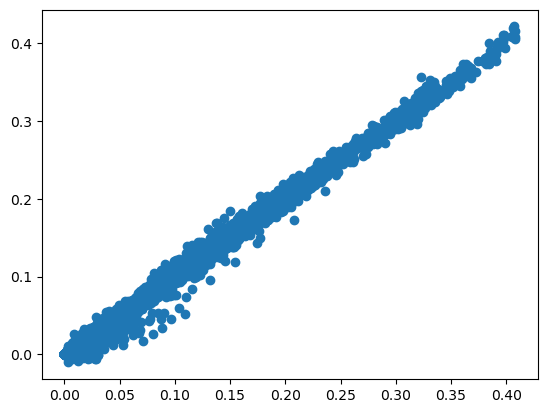

In [32]:
plt.scatter(preds, Y)

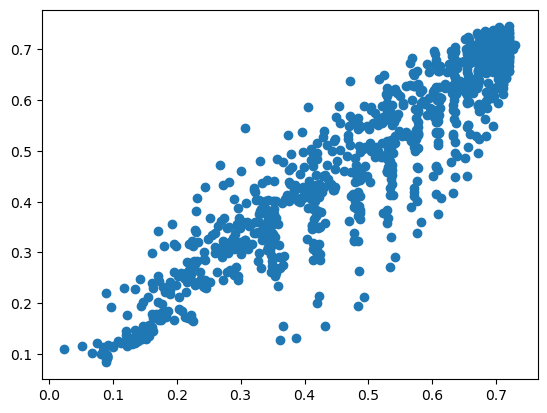

In [16]:
plt.scatter(np.sum(preds[:,1:,:], -1), Y[:,1:,0])

In [17]:
# predict
X, U, Y, test_exp_names = format_data(full_data_dt, species, metabolites, controls, observed=species)
preds, stdvs, COV = brnn.predict(X, U)

[0.05279351 0.04088138 0.00879966 0.09114886 0.00906525]


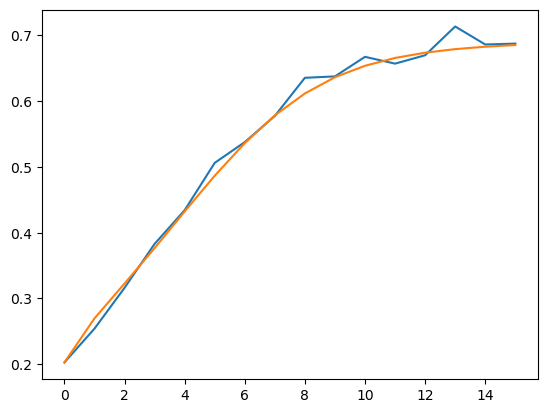

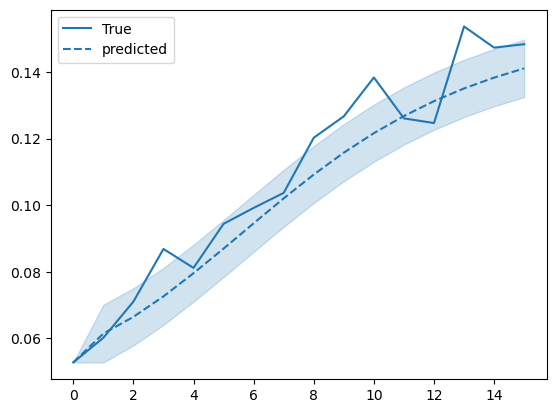

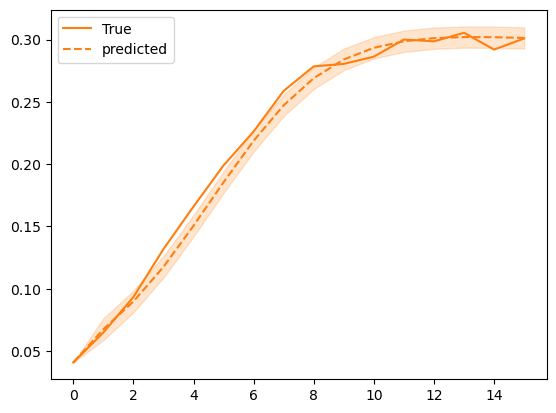

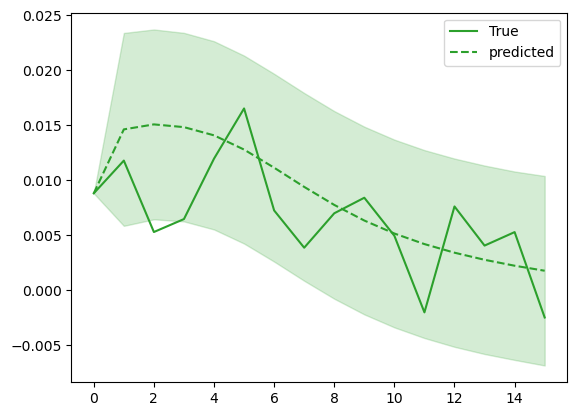

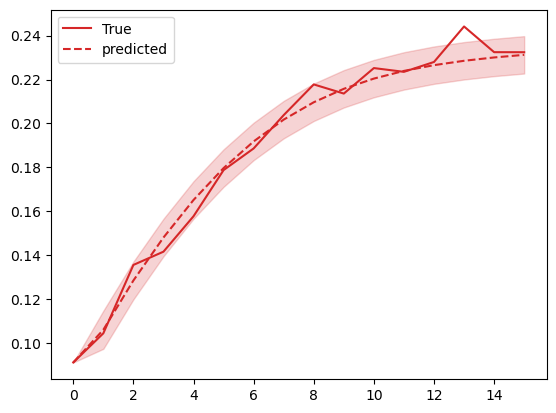

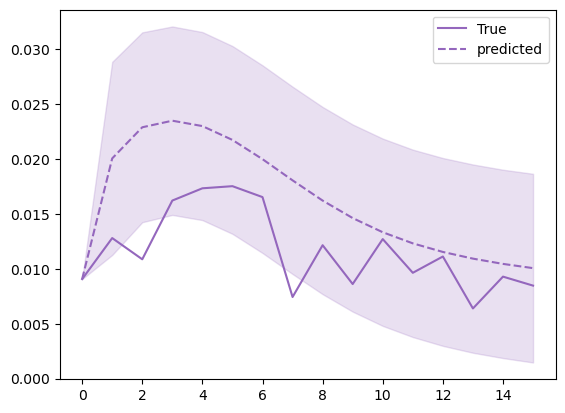

In [39]:
sample = 21
print(X[sample])

plt.plot(np.sum(Y[sample], -1))
plt.plot(np.sum(preds[sample], -1))
plt.show()

for i in range(ns):
    plt.plot(Y[sample,:,i], c=f"C{i}", label="True")
    plt.plot(preds[sample,:,i], c=f"C{i}", linestyle="--", label="predicted")
    plt.fill_between(np.arange(preds[sample].shape[0]), 
                     preds[sample,:,i] - stdvs[sample,:,i],
                     preds[sample,:,i] + stdvs[sample,:,i], 
                     color=f"C{i}", alpha=.2)
    plt.legend()
    plt.show()